#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션)각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션)각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input ,SimpleRNN,LSTM,Flatten
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping # 미리멈춤에 필요

from tensorflow.keras.models import Model  # Funtional에 필요

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
data=pd.read_csv(path+'data01_train.csv')
test=pd.read_csv(path+'data01_test.csv')
feature=pd.read_csv(path+'features.csv')

In [6]:
data.drop(columns='subject',inplace=True)
test.drop(columns='subject',inplace=True)

#### 2) 기본 정보 조회

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [8]:
data.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y

In [9]:
data.shape

(5881, 562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
target='Activity'
x=data.drop(columns=target)
y=data.loc[:,target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x=scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
y= encoder.fit_transform(y)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [13]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=.2,random_state=1)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

## EarlyStopping 미리 멈춤

In [14]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터할 지표
    patience=5,          # 성능 개선이 없는 에폭 수
    restore_best_weights=True  # 최상의 가중치 복원
)

### Base 모델

In [15]:
n=x_train.shape[1]
n

561

In [16]:
# y가 numpy array일 때
num_classes = np.unique(y).size  # 고유한 값의 개수
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [17]:
clear_session()

model=Sequential([Input(shape=(n,)),
                  Dense(6, activation='softmax')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy')

history=model.fit(x_train,y_train,epochs=5, validation_split=0.2,verbose=0).history

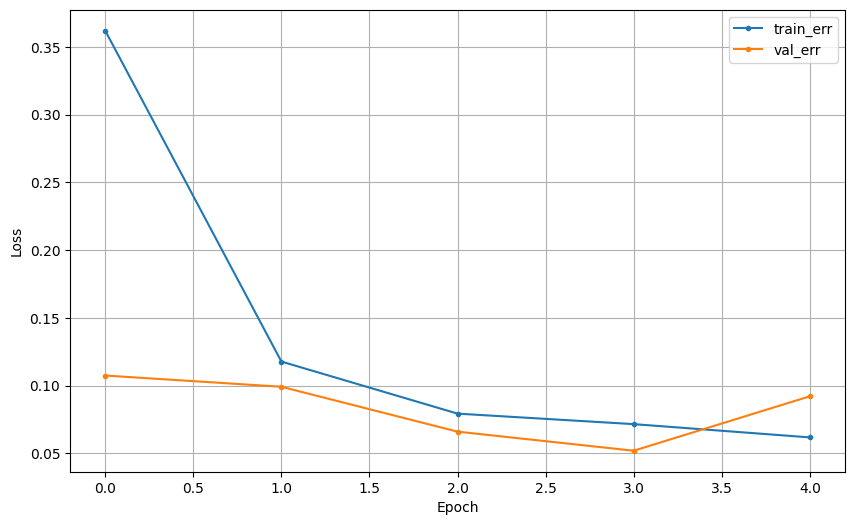

In [19]:
dl_history_plot(history)

In [20]:
pred = model.predict(x_val)
pred = np.argmax(pred, axis=1)  # 클래스 확률을 가장 높은 클래스로 변환

print(accuracy_score(y_val, pred))
print(mean_absolute_error(y_val,pred))
print(classification_report(y_val, pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.9532710280373832
0.05012744265080714
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       222
           1       0.96      0.78      0.86       198
           2       0.83      0.99      0.90       235
           3       0.99      0.99      0.99       192
           4       1.00      0.99      1.00       156
           5       1.00      0.99      1.00       174

    accuracy                           0.95      1177
   macro avg       0.96      0.95      0.96      1177
weighted avg       0.96      0.95      0.95      1177



### (1) 모델1

In [21]:
clear_session()

model1=Sequential([Input(shape=(n,)),
                  Dense(350,activation='relu'),
                  Dense(250,activation='relu'),
                  Dense(100,activation='relu'),
                  Dense(70,activation='relu'),
                  Dense(6,activation='softmax')])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 350)                 │         196,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 250)                 │          87,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 70)                  │           7,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             426 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,046 (1.21 MB)

 Trainable params: 317,046 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model1.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist1=model1.fit(x_train,y_train,epochs=10,validation_split=.2,verbose=0).history

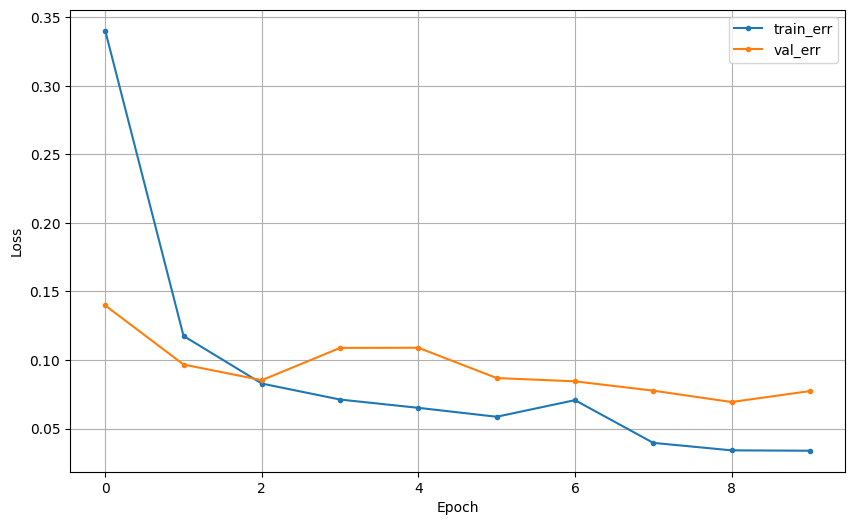

In [23]:
dl_history_plot(hist1)

In [24]:
pred1=model1.predict(x_val)
pred1=np.argmax(pred1,axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [25]:
print(classification_report(y_val, pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.90      0.93      0.92       198
           2       0.94      0.91      0.93       235
           3       1.00      1.00      1.00       192
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       174

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



### (2) 모델2-Funtional

In [26]:
n=x_train.shape[1]
n

561

In [27]:
clear_session()

il = Input(shape=(n, ))
hl1 = Dense(200, activation='relu')(il)
hl2 = Dense(100, activation='relu')(hl1)
ol = Dense(6,activation='softmax')(hl2)


model2=Model(inputs=il,outputs=ol)

model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 561)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │         112,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,106 (519.95 KB)

 Trainable params: 133,106 (519.95 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model2.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist2=model2.fit(x_train,y_train,epochs=20,validation_split=.2,verbose=0, callbacks=[early_stopping]).history

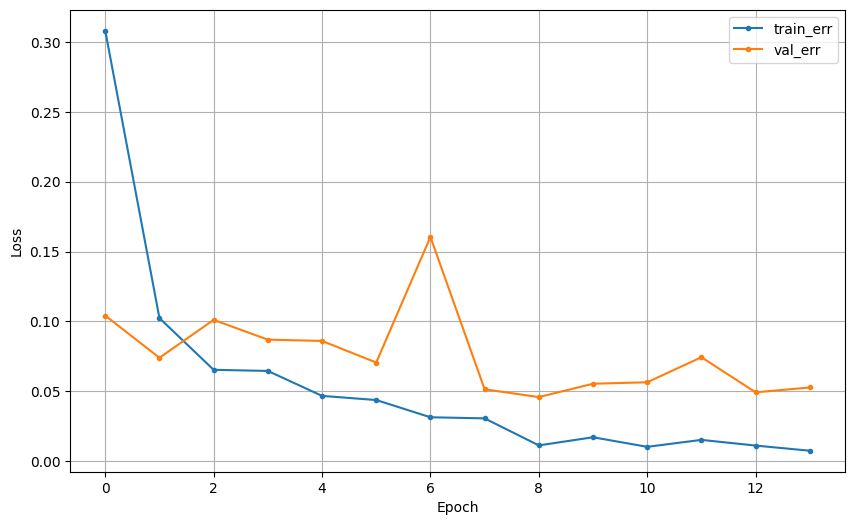

In [29]:
dl_history_plot(hist2)

In [30]:
pred2=model2.predict(x_val)
pred2=np.argmax(pred2,axis=1)

print(classification_report(y_val, pred2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.96      0.95      0.96       198
           2       0.96      0.97      0.97       235
           3       0.99      1.00      0.99       192
           4       1.00      0.99      1.00       156
           5       1.00      0.99      1.00       174

    accuracy                           0.98      1177
   macro avg       0.99      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (3) 모델3-Functional2

In [31]:
clear_session()

il = Input(shape=(n, ))
hl1 = Dense(200, activation='relu')(il)
hl2 = Dense(100, activation='relu')(hl1)
hl3 = Dense(50, activation='relu')(hl2)
hl4 = Dense(25, activation='relu')(hl3)
ol = Dense(6,activation='softmax')(hl4)


model3=Model(inputs=il,outputs=ol)

In [32]:
model3.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist3=model3.fit(x_train,y_train,epochs=20,validation_split=.2,verbose=0, callbacks=[early_stopping]).history

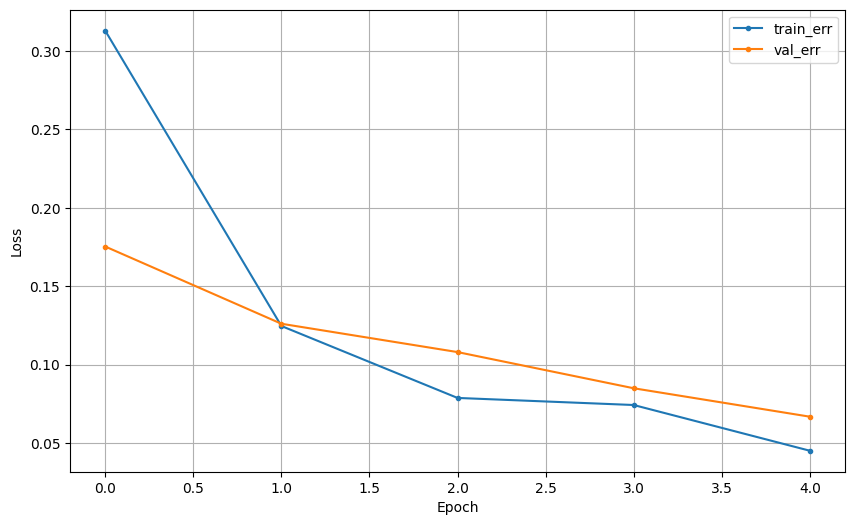

In [33]:
dl_history_plot(hist3)

In [34]:
pred3=model3.predict(x_val)
pred3=np.argmax(pred3,axis=1)

print(classification_report(y_val, pred3))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       222
           1       0.96      0.83      0.89       198
           2       0.87      0.97      0.92       235
           3       0.98      0.95      0.97       192
           4       1.00      0.83      0.91       156
           5       0.83      1.00      0.91       174

    accuracy                           0.93      1177
   macro avg       0.94      0.93      0.93      1177
weighted avg       0.94      0.93      0.93      1177



### (4) 모델4-RNN

### RNN전처리

In [35]:
x.shape, y.shape

((5881, 561), (5881,))

3차원 구조만들기 및 전처리

In [36]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

In [37]:
x2,y2=temporalize(x,y,4)
x2.shape,y2.shape

((5878, 4, 561), (5878,))

In [108]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [38]:
x2[:2]

array([[[ 0.20259561,  0.21824757,  0.10337138, ..., -0.21535098,
          0.91485287,  0.78920229],
        [-0.13392169,  0.03104029,  0.19244103, ...,  1.64374068,
         -2.78655867, -0.33524448],
        [ 0.05766163,  0.08340823,  0.01162337, ..., -0.67199598,
          0.48142564,  0.07843035],
        [ 0.22163113, -0.44995432, -0.70172622, ..., -0.40139158,
          0.76637521,  0.59608037]],

       [[-0.13392169,  0.03104029,  0.19244103, ...,  1.64374068,
         -2.78655867, -0.33524448],
        [ 0.05766163,  0.08340823,  0.01162337, ..., -0.67199598,
          0.48142564,  0.07843035],
        [ 0.22163113, -0.44995432, -0.70172622, ..., -0.40139158,
          0.76637521,  0.59608037],
        [ 1.77488732,  1.31657369,  3.43724807, ..., -0.41948385,
          0.69170014,  0.69078146]]])

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 0.2, shuffle = False)

In [40]:
x_train.shape, y_train.shape

((4702, 4, 561), (4702,))

In [41]:
x_val.shape, y_val.shape

((1176, 4, 561), (1176,))

In [42]:
timesteps = x_train.shape[1]
n = x_train.shape[2]

timesteps,n

(4, 561)

모델링

In [43]:
clear_session()

model4=Sequential([Input(shape=(timesteps,n)),
                  SimpleRNN(16,return_sequences=True),
                  SimpleRNN(8),
                  Flatten(),
                  Dense(10,activation='relu'),
                  Dense(6,activation='softmax')])

model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 4, 16)               │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,604 (37.52 KB)

 Trainable params: 9,604 (37.52 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model4.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist4=model4.fit(x_train,y_train,epochs=20,validation_split=.2,verbose=0).history

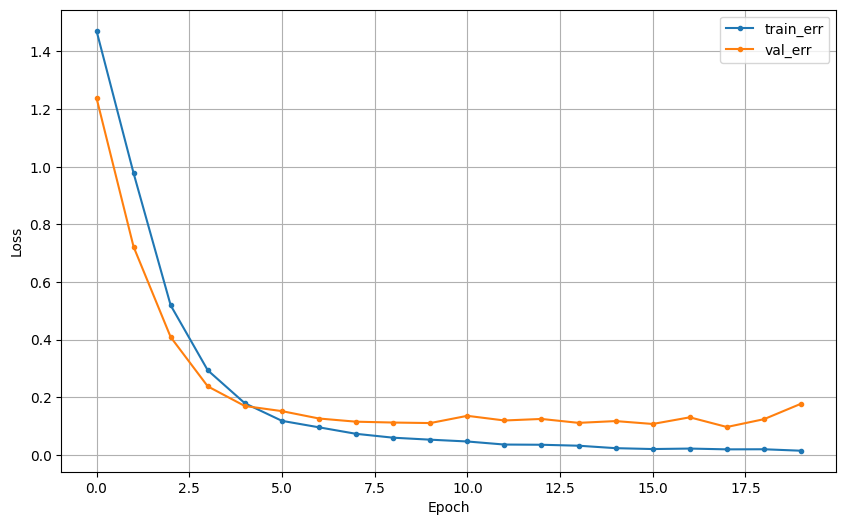

In [45]:
dl_history_plot(hist4)

In [46]:
pred4=model4.predict(x_val)
pred4=np.argmax(pred4,axis=1)

print(classification_report(y_val, pred4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       233
           1       0.97      0.88      0.92       205
           2       0.90      0.98      0.94       220
           3       0.95      1.00      0.97       189
           4       1.00      0.99      0.99       153
           5       0.99      0.95      0.97       176

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



### (5) 모델5-LSTM

In [101]:
clear_session()

model5 = Sequential([Input(shape = (timesteps, n)),
                    LSTM(8, return_sequences = True),
                    LSTM(8),
                    Dense(6,activation='softmax')])

model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 8)                │          18,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,838 (73.59 KB)

 Trainable params: 18,838 (73.59 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model5.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist5=model5.fit(x_train,y_train,epochs=10,validation_split=.2,verbose=0).history

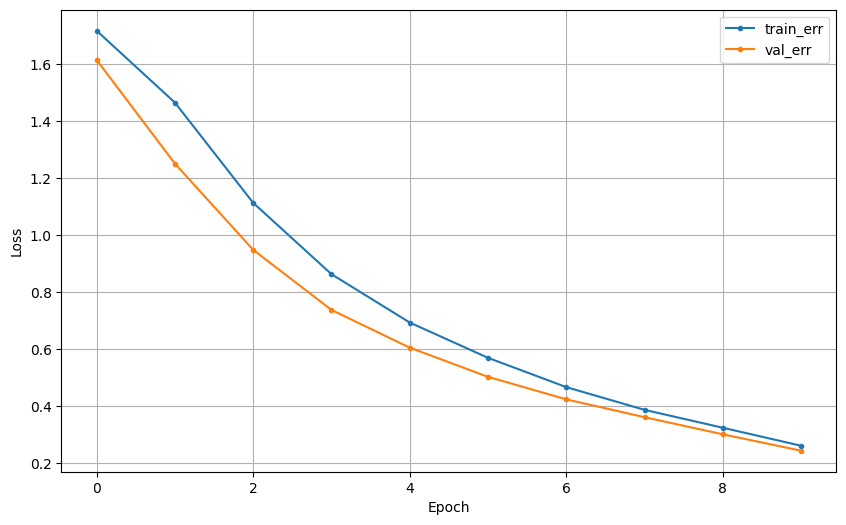

In [103]:
dl_history_plot(hist5)

In [104]:
pred5=model5.predict(x_val)
pred5=np.argmax(pred5,axis=1)

print(classification_report(y_val, pred5))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       0.88      0.94      0.91       205
           2       0.95      0.88      0.91       220
           3       0.99      1.00      0.99       189
           4       0.97      0.98      0.97       153
           5       0.98      0.96      0.97       176

    accuracy                           0.96      1176
   macro avg       0.96      0.96      0.96      1176
weighted avg       0.96      0.96      0.96      1176



## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정